# Perception on Public Security in the United States of Mexico

## Introduction

After a recent trip to Mexico, I decided to explore the website of the National Institute of Statistics and Geography of Mexico ([INEGI](https://en.www.inegi.org.mx/default.html)) and use this project as an opportunity to learn more about the country. 

After exploring the data available on the website, I decided to investigate the issue perceived security within the country. I chose this topic for 2 main reasons: 

1) While planning my trip, I was surprised for the concern expressed by my Mexican friends (both male and female). Also, during my trip, I noticed that my own perception of security (or lack thereof) was different, based on the state and town I was visiting. 

2) The data available on the INEGI website looks complex and interesting enough to investigate: the survey has been iterated for a number of years (yearly, from 2010 to 2025), and it's divided by state, which allows both a temporal and a geographic analysis. 

### Project scope

The goal of this project is to investigate the following points: 

- How has the perception of public security changed in the past 15 years, by sex and by state? 
- How does it look like, now? 
- How does it related with the crime rate? 

## 1. Data import

All the packages required for the project are imported.

In [2]:
import pandas as pd
import numpy as np
import requests 
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

### 1.1 API requests and download

After exploring the webiste of INEGI, I found 2 ways of sourcing the data: 

- using the API 
- dowloading the data in .xlsx format. 

I explored both ways. 

#### API requests

The API requires a token (or key), which can be requested for free by registering with an email address. The API requests can be created using a [Query Builder](https://en.www.inegi.org.mx/servicios/api_indicadores.html) that inputs parameters such as: 

- indicator,
- geographic area,
- language (Spanish or English).

The [documentation](https://en.www.inegi.org.mx/servicios/api_indicadores.html) is quite clear and accessible, and available in Spanish and English.

However, the API has some limitations:

1. it returns responses in .json, .jsonp, or .xml, which make it hard to read and manipulate the data with Pandas (see below);
2. it only allows to request data about one area at the time, which does not allow to compare data points across regions;
3. it allows to input max 10 indicators per request, which returns a partial dataset and limits analysis.

In [3]:
# code provided by chatGPT: https://chatgpt.com/share/6950450b-d294-800f-8cb4-c585e1a7fe7f

# 1. Fetch the JSON from the API
url = "https://en.www.inegi.org.mx/app/api/indicadores/desarrolladores/jsonxml/INDICATOR/6200028417,6200028418,6200028419,6200028420,6200028431,6200028430,6200028427,6200028425,6200028423,6200028433/en/00,01/true/BISE/2.0/0f18317c-23e8-90bd-c373-f2e07a38e907?type=json"
response = requests.get(url)
data = response.json()  # Convert response to Python dict

# 2. Create a DataFrame from the "Series" list
series_df = pd.json_normalize(data["Series"])

# 3. Also flatten the "OBSERVATIONS" nested list
obs_df = pd.json_normalize(
    data["Series"],
    record_path=["OBSERVATIONS"],
    meta=["INDICADOR"],
    errors="ignore"
)

# 4. Merge Series-level with Observations
df = series_df.drop(columns=["OBSERVATIONS"]).merge(
    obs_df,
    on="INDICADOR",
    how="inner"
)

# preview data 
df.head(5)

,INDICADOR,FREQ,TOPIC,UNIT,UNIT_MULT,NOTE,SOURCE,LASTUPDATE,STATUS,TIME_PERIOD,OBS_VALUE,OBS_EXCEPTION,OBS_STATUS,OBS_SOURCE,OBS_NOTE,COBER_GEO
0,6200028417,3,163,3,,,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,34.35740488780000000000,None,3,,,0
1,6200028418,3,163,3,,5255,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,18.44711426750000000000,None,3,,,0
2,6200028419,3,163,3,,5256,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,63.80192530400000000000,None,3,,,0
3,6200028420,3,163,3,,5257,"1024,1027,1054,1171,1795,2196,2782,2822,2928,2...",18/09/2025 12:00:00 a. m.,None,2025,23.72884692830000000000,None,3,,,0
4,6200028431,3,163,3,,5267,"1024,1054,1171,1795,2196,2782,2822,2928,2974,2...",18/09/2025 12:00:00 a. m.,None,2025,16.67994456540000000000,None,3,,,0


Reading the API response with Pandas is not particularly easy, nor straightforward (it's not enough to use [pandas.read_json()](https://pandas.pydata.org/docs/reference/api/pandas.read_json.html)). 

Morever, once the data is imported to a dataframe, it is still quite hard to read, because indicators and geographic areas are identified with IDs instead of full names, so they should be remapped.

It would be possible to make the data complete, creating multiple requests (iterating through areas and indicators) and remapping names. However, this would add complexity to the task. For this reason, I decided the most effective way of sourcing the data was downloading the full dataset in .xlsx format. 

#### Data download

The datasets available on the website of INEGI in .xlsx format include multiple tabs: one for the data, and one or more for metadata. See: https://en.www.inegi.org.mx/app/descarga/?t=163. 

The dataset on *Perception of Public Security* was downloaded and added to the repository in the folder *data*: [Perception dataset](project/data/percepcion_english_00.xlsx). It includes 3 tabs: 

- the dataset,
- metadata for each indicator and for each year,
- metadata on each indicator. 

Pandas.read_excel is used to read the full dataset (1st tab of the file). 

The dataset includes all the indicators and geographic areas, including IDs and full names. 

In [4]:
# set file path 
filepath = "./data/public_security.xlsx"

# read data. See: # see: https://pandas.pydata.org/docs/reference/api/pandas.read_json.html
df = pd.read_excel(filepath, sheet_name='valor', skiprows=4)

# preview the data
df.head()

,cve_entidad,desc_entidad,cve_municipio,desc_municipio,id_indicador,indicador,2010,2011,2012,2013,...,2023/t4,2024,2024/t1,2024/t2,2024/t3,2024/t4,2025,2025/t1,2025/t2,unidad_medida
0,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002198,Rate of people aged 18 and older who considere...,NaN,69536.343084,66622.674217,72322.456768,...,NaN,73621.540745,NaN,NaN,NaN,NaN,75556.050590,NaN,NaN,"Cases per 100,000 inhabitants"
1,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002235,Rate of economic units that consider their nei...,NaN,NaN,5460.456292,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
2,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002237,Rate of economic units that consider their sta...,NaN,NaN,7602.826537,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
3,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200002238,Rate of economic units that consider their mun...,NaN,NaN,7052.320400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Cases per 10,000 economic units"
4,0,Estados Unidos Mexicanos,0,Estados Unidos Mexicanos,6200005815,Rate of people aged 18 years and over that con...,NaN,39481.723643,38674.118886,44011.361167,...,NaN,40210.785898,NaN,NaN,NaN,NaN,40462.996387,NaN,NaN,"Cases per 100,000 inhabitants"


The dataset is saved to .csv format in the folder "data", so the file can be opened from the repository (which is not possible for .xlsx). 

In [5]:
# save dataframe to csv. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html
df.to_csv('./data/public_security.csv', index=False)

### 1.2 Data exploration

The dataset is explored to know more about its size and data points.  

#### Series

Series (or columns) are explored. The dataset includes 69 columns: 

- the first columns (0-5) provide information on the geographic area and indicators and values: IDs could be removed to make the dataset easier to handle. 
- the rest of the columns provodide quarterly data (ES: *trimester*, or *t*), recorded from 2010 through 2025. Many of these columns are near empty, so they should be removed to keep only yearly data. 
- the last column provides information on the value types (absolute numbers, percentages, units per 100,000 inhabitants), which is useful to understand values. 

Data types are a mix of strings (objects) and integers (IDs) and floats (values). 

In [6]:
# show series and data types. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.info.html
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1485 entries, 0 to 1484
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cve_entidad     1485 non-null   int64  
 1   desc_entidad    1485 non-null   object 
 2   cve_municipio   1485 non-null   int64  
 3   desc_municipio  1485 non-null   object 
 4   id_indicador    1485 non-null   int64  
 5   indicador       1485 non-null   object 
 6   2010            14 non-null     float64
 7   2011            1351 non-null   float64
 8   2012            1451 non-null   float64
 9   2013            1352 non-null   float64
 10  2013/t3         1 non-null      float64
 11  2013/t4         1 non-null      float64
 12  2014            1451 non-null   float64
 13  2014/t1         1 non-null      float64
 14  2014/t2         1 non-null      float64
 15  2014/t3         1 non-null      float64
 16  2014/t4         1 non-null      float64
 17  2015            1352 non-null   f

#### Geographic areas

Two data points refer to geographic areas: desc_entidad (EN: *entity*) and desc_municipio (*municipality*). Both are listed to understand their meaning. 

In [7]:
# show unique values of 'desc_entidad'. see: https://pandas.pydata.org/docs/reference/api/pandas.Series.unique.html
df['desc_entidad'].unique()

array(['Estados Unidos Mexicanos', 'Aguascalientes', 'Baja California',
       'Baja California Sur', 'Campeche', 'Coahuila de Zaragoza',
       'Colima', 'Chiapas', 'Chihuahua', 'Ciudad de México', 'Durango',
       'Guanajuato', 'Guerrero', 'Hidalgo', 'Jalisco', 'México',
       'Michoacán de Ocampo', 'Morelos', 'Nayarit', 'Nuevo León',
       'Oaxaca', 'Puebla', 'Querétaro', 'Quintana Roo', 'San Luis Potosí',
       'Sinaloa', 'Sonora', 'Tabasco', 'Tamaulipas', 'Tlaxcala',
       'Veracruz de Ignacio de la Llave', 'Yucatán', 'Zacatecas'],
      dtype=object)

In [8]:
# show unique values of 'desc_municipio'
df['desc_municipio'].unique()

array(['Estados Unidos Mexicanos', 'Estatal'], dtype=object)

Desc_municipio refers to the country, while desc_entitad to the State, which is the relevant information. 

#### Indicators

The Excel tab with metadata on indicators is imported to know more about the number and type of indicators. 

In [9]:
# show indicators 
indicators = pd.read_excel(filepath, sheet_name='notas', skiprows = 4)

# show
indicators.head()

,id,indicador,descripcion
0,6200002198,Rate of people aged 18 and older who considere...,The rate of people who feel their state is ins...
1,6200002198,Rate of people aged 18 and older who considere...,Due to the health emergency generated by the S...
2,6200002198,Rate of people aged 18 and older who considere...,Due to the health emergency generated by the S...
3,6200002235,Rate of economic units that consider their nei...,The rate of economic units that considered uns...
4,6200002237,Rate of economic units that consider their sta...,The rate of economic units that considered uns...


Some indicators seem to be duplicates, which creates some noise. 

In [10]:
# show count of indicators (by id)
print(f'Number of indicators (ID): {len(indicators['id'])}')

# show count of unique indicators (by id)
print(f'Unique indicators (ID): {len(indicators['id'].unique())}')

Number of indicators (ID): 86
Unique indicators (ID): 59


In [11]:
# show unique indicators 
list(indicators['indicador'].unique())

['Rate of people aged 18 and older who considered unsafe their state, for every hundred thousand inhabitants of 18 years and over',
 'Rate of economic units that consider their neighborhood or locality as unsafe, per ten thousand economic units',
 'Rate of economic units that consider their state as unsafe, per ten thousand economic units',
 'Rate of economic units that consider their municipality or delegation as unsafe, per ten thousand economic units',
 'Rate of people aged 18 years and over that consider their neighborhood or locality as unsafe, per hundred thousand population aged 18 years and over',
 'Rate of people aged 18 years and over that consider their municipality or delegation as unsafe, per hundred thousand population aged 18 years and over',
 'Percentage of population aged 18 years and over who consider unsafe their city',
 'Percentage of depositions of venues invasion',
 'Percentage of depositions of alcohol consumption in the street',
 'Percentage of depositions of ho

Indicators provide information on: 

- people's perception on public safety within their area (from neighborhood to state). Values expressed either as rates, rate per 100,000 inhabitants, or absolute numbers, by sex and in total. 

- pecentage of depositions for several crime types.

- perception of corruption / insecurity by the population. 

Duplicate rows are removed, and the indicators are saved to a .csv file in the folder [Data](./data). 

In [12]:
# remove duplicate rows by id. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html
indicators.drop_duplicates(subset=['id'], inplace=True)

# save to csv 
indicators.to_csv('./data/indicators.csv', index=False)

## 2. Data cleanup

### 2.1 Remove columns

Irrelevant columns are removed from the dataframe

- cve_minicipio and disc_municipio (which have the same values throughout the whole dataset),
- columns about quarterly data (which are mostly empty).

In [13]:
# remove entidad. See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
data = df.drop(columns=['cve_municipio', 'desc_municipio'])

# remove quarterly data. See: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.filter.html
data = data.filter(regex = "^[a-z0-9_]+(?!\t)$", axis = 1)

### 2.2 Label Translation

Untranslated labels are replaced with labels in English to enhance clarity.

In [14]:
# translate column labels
new_columns = {
    'cve_entidad': 'state ID',
    'desc_entidad': 'state',
    'indicador': 'indicator',
    'id_indicador': 'indicator ID',
    'unidad_medida': 'unit of measure'}

# rename columns. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rename.html
data.rename(columns=new_columns, inplace=True)

### 2.3 Missing values

Columns are explored to identify and remove missing values. From the first exploration of the data (see cell 5), it is known that the total number of rows in the dataset is 1485. 

In [15]:
# count missing values
data.isnull().sum()

state ID              0
state                 0
indicator ID          0
indicator             0
2010               1471
2011                134
2012                 34
2013                133
2014                 34
2015                133
2016                  1
2017                100
2018                  1
2019                166
2020                 67
2021                199
2022                 34
2023                133
2024                133
2025                148
unit of measure       0
dtype: int64

#### Dealing with missing values 

A number of strategies were considered to deal with missing values: 

- removing columns and/or rows, which means that some data points are lost entirely. 
- imputation: adding to the cell the median/mean value of the series, optionally based on the values in another series. This is useful if few instances is missing; if a large amount of data points are missing, it can result in a loss of variation in the dataset. 
- forward fill and backward fill: carrying forward the last observed value, or carrying backward the next value (useful for time series). 

Source: https://medium.com/@pingsubhak/handling-missing-values-in-dataset-7-methods-that-you-need-to-know-5067d4e32b62. 

For this dataset, the strategy is: 

- removing the column 2010 entirely, since most values are missing. 
- removing rows with empty values [not the best approach, because it means that data on some States is lost entirely. This might be changed at a later stage]. 


In [16]:
# drop column 2010
data.drop(['2010'], axis = 1, inplace=True)

# drop rows with missing values. See:  https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.dropna.html
data.dropna(inplace=True)

After empty columns and rows are removed from the dataframe, the total number of rows is 1238 (247 less than the original dataframe). 

In [17]:
# show columns 
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1238 entries, 0 to 1484
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   state ID         1238 non-null   int64  
 1   state            1238 non-null   object 
 2   indicator ID     1238 non-null   int64  
 3   indicator        1238 non-null   object 
 4   2011             1238 non-null   float64
 5   2012             1238 non-null   float64
 6   2013             1238 non-null   float64
 7   2014             1238 non-null   float64
 8   2015             1238 non-null   float64
 9   2016             1238 non-null   float64
 10  2017             1238 non-null   float64
 11  2018             1238 non-null   float64
 12  2019             1238 non-null   float64
 13  2020             1238 non-null   float64
 14  2021             1238 non-null   float64
 15  2022             1238 non-null   float64
 16  2023             1238 non-null   float64
 17  2024             12

## 3. Analysis: Perception of insecurity, by sex 

**About this section**

This section investigates how the perception of insecurity by men and women has evolved in the year range 2011-2025, both about their State and their Municipality. The goal is to compare trends by sex and by indicator.    


The indicators considered are: 
1) 6204327084, Rate of people aged 18 years and over **who consider their state to be unsafe**, per every one hundred thousand inhabitants aged 18 years and over, **men**

2) 6204327085, Rate of people aged 18 years and over **who consider their state insecure**, per every one hundred thousand inhabitants aged 18 and over, **women**

3) 6204327086, Rate of people aged 18 years and over **who consider their municipality or delegation to be unsafe**, per every one hundred thousand inhabitants aged 18 years and over, **men**

4) 6204327087, Rate of people aged 18 years and over **who consider their municipality or delegation to be unsafe**, per every one hundred thousand inhabitants aged 18 years and over, **women**. 

### 3.1 Data preparation

A subset with the relevant data is extracted from the dataframe, based on these criteria:

- the four indicators above 
- the state = United States of Mexico (national average). 

In [18]:
# select subset for indicators by sex 
security_data = data[(data['indicator ID']== 6204327084) | (data['indicator ID']== 6204327085) | (data['indicator ID']== 6204327086) | (data['indicator ID']== 6204327087) ]
# select subset for indicators by state (United States of Mexico))
security_data = security_data[security_data['state ID'] == 0]

# set indicators as index 
security_data = security_data.set_index('indicator ID')

# show 
security_data.head(3)

,state ID,state,indicator,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,unit of measure
indicator ID,,,,,,,,,,,,,,,,,,,
6204327084,0,Estados Unidos Mexicanos,Rate of people aged 18 years and over who cons...,66890.111026,64118.476781,69617.056542,69789.398905,69813.951453,69029.295661,71300.086465,76298.049687,75402.185998,74667.832897,72008.054681,71839.184476,70000.913221,69298.906629,70949.460191,"Cases per 100,000 inhabitants"
6204327085,0,Estados Unidos Mexicanos,Rate of people aged 18 years and over who cons...,71943.225612,68777.403637,74716.102503,76267.501601,76163.569081,75261.596065,76935.362086,82101.835803,82042.436583,81735.064641,78792.132963,79410.575547,78604.856014,77294.414283,79426.707086,"Cases per 100,000 inhabitants"
6204327086,0,Estados Unidos Mexicanos,Rate of people aged 18 years and over who cons...,56802.709413,55164.694724,60014.419763,60833.322193,60470.173236,61727.239273,62695.309034,66166.464847,66328.786362,66372.520385,61386.332953,60334.784798,58384.108149,57708.657000,59572.400731,"Cases per 100,000 inhabitants"


Metadata is removed, so that the only columns left are: 
- indicator ID 
- yearly values. 

In [19]:
# remove unnecessary columns 
col_to_remove = ['state ID', 'state','indicator','unit of measure']

security_data.drop(columns=col_to_remove, inplace=True)

# show
security_data.head(3)

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
indicator ID,,,,,,,,,,,,,,,
6204327084,66890.111026,64118.476781,69617.056542,69789.398905,69813.951453,69029.295661,71300.086465,76298.049687,75402.185998,74667.832897,72008.054681,71839.184476,70000.913221,69298.906629,70949.460191
6204327085,71943.225612,68777.403637,74716.102503,76267.501601,76163.569081,75261.596065,76935.362086,82101.835803,82042.436583,81735.064641,78792.132963,79410.575547,78604.856014,77294.414283,79426.707086
6204327086,56802.709413,55164.694724,60014.419763,60833.322193,60470.173236,61727.239273,62695.309034,66166.464847,66328.786362,66372.520385,61386.332953,60334.784798,58384.108149,57708.657000,59572.400731


The data is transposed, so that indicators become columns, and years become the index of the dataframe. 

In [20]:
# transpose data. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transpose.html
new_security_data = security_data.transpose()

# rename columns
new_security_data.columns = ['State, Men', 'State, Women','Municipality, Men', 'Municipality, Women']

# preview new data
new_security_data.head(3)

,"State, Men","State, Women","Municipality, Men","Municipality, Women"
2011,66890.111026,71943.225612,56802.709413,63393.150545
2012,64118.476781,68777.403637,55164.694724,60575.019740
2013,69617.056542,74716.102503,60014.419763,65578.422145


### 3.2 Plots: show the data in subplots

Two subplots are created to show: 
- rate of people aged 18 or more who perceive their State as insecure, by sex,
- rate of people aged 18 or more who perceive their Municipality as insecure, by sex. 

I chose to represent the value expressed for every 100,000 inhabitants, instead of the total number (which is also provided in the original dataset), becuase this unit of measure makes the plot easier to read and gives a better idea of proportoion (rate of insecurity/total population).

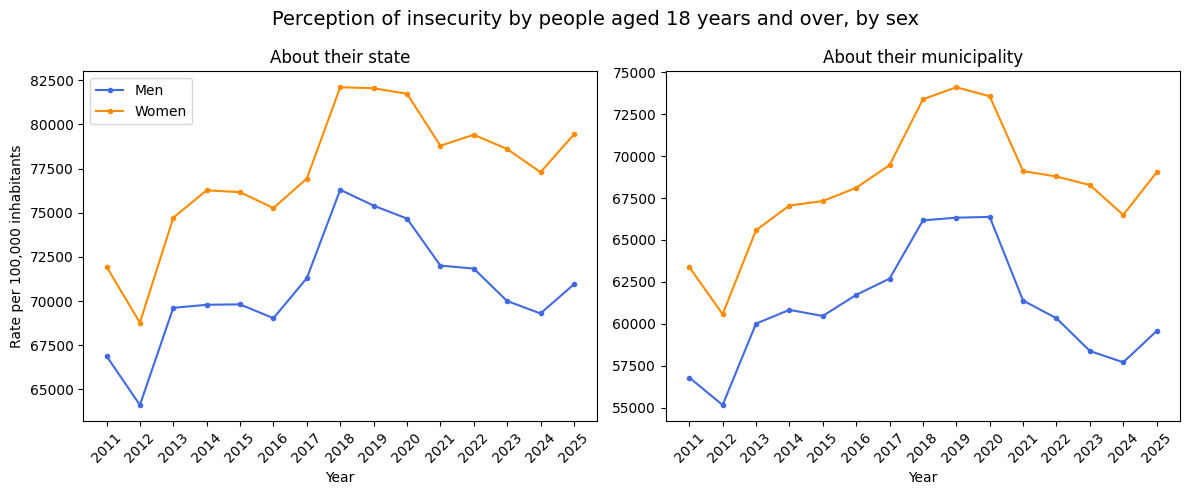

In [21]:
# create subplots: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True)

axes[0].plot(new_security_data.index, new_security_data['State, Men'], color = 'royalblue', label = 'Men', marker = '.')
axes[0].plot(new_security_data.index, new_security_data['State, Women'], color = 'darkorange', label = 'Women', marker = '.')
axes[0].set_title('About their state', wrap = True)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Rate per 100,000 inhabitants')
axes[0].tick_params("x", rotation=45)
axes[0].legend(loc='upper left')

axes[1].plot(new_security_data.index, new_security_data['Municipality, Men'],color = 'royalblue', label = 'Men', marker = '.')
axes[1].plot(new_security_data.index, new_security_data['Municipality, Women'], color = 'darkorange', label = 'Women', marker = '.')
axes[1].set_title('About their municipality', wrap = True)
axes[1].set_xlabel('Year')
axes[1].tick_params("x", rotation=45)

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html
plt.suptitle('Perception of insecurity by people aged 18 years and over, by sex', size = 14)
plt.tight_layout()
plt.show()

#### [REMOVE] Plots: compare data with the same plot

A plot is created to show all indicators in the same plot, which allows to better understand the numerical difference in trends. 

In [22]:
'''
# https://seaborn.pydata.org/generated/seaborn.lineplot.html
sns.lineplot(x = new_security_data.index, y = new_security_data['State, Men'], color = 'royalblue', label = 'State, Men')

sns.lineplot(x = new_security_data.index, y = new_security_data['State, Women'], color = 'darkorange', label = 'State, Women')

sns.lineplot(x = new_security_data.index, y = new_security_data['Municipality, Men'], color = 'royalblue', linestyle = 'dashed', label = 'Municipality, Men')

sns.lineplot(x = new_security_data.index, y = new_security_data['Municipality, Women'], color = 'darkorange', linestyle = 'dashed', label = 'Municipality, Women')


plt.legend(loc = 'lower right', fontsize = 'small')
plt.xlabel('Year')
plt.ylabel('Rate per 100,000 inhabitants')
plt.xticks(rotation=45)
plt.title('State vs Municipality', size = 10)
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html
plt.suptitle('Perception of insecurity by people aged 18 years and over, by sex', size = 12)

plt.show()
'''

"\n# https://seaborn.pydata.org/generated/seaborn.lineplot.html\nsns.lineplot(x = new_security_data.index, y = new_security_data['State, Men'], color = 'royalblue', label = 'State, Men')\n\nsns.lineplot(x = new_security_data.index, y = new_security_data['State, Women'], color = 'darkorange', label = 'State, Women')\n\nsns.lineplot(x = new_security_data.index, y = new_security_data['Municipality, Men'], color = 'royalblue', linestyle = 'dashed', label = 'Municipality, Men')\n\nsns.lineplot(x = new_security_data.index, y = new_security_data['Municipality, Women'], color = 'darkorange', linestyle = 'dashed', label = 'Municipality, Women')\n\n\nplt.legend(loc = 'lower right', fontsize = 'small')\nplt.xlabel('Year')\nplt.ylabel('Rate per 100,000 inhabitants')\nplt.xticks(rotation=45)\nplt.title('State vs Municipality', size = 10)\n# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.suptitle.html\nplt.suptitle('Perception of insecurity by people aged 18 years and over, by sex', siz

### 3.3 Analysis 


State vs municipality: 
1) on average people are less confident about their municiplaity than the state. calculate average difference for both men and women 
2) similar patten: insecurity increased between 2012-2019, declining from 2020 (presidents: Nieto / Obrador / Sheinbaum). 
3) there are peaks corresponding to elections: people are hopeful things will improve? 

Women vs men
1) similar pattern, with women more concerned about security. calculate average difference between women and men, by state and municipality. 

## 4. Perception of insecurity, by state

**About this section** 

This section investigates the perception of insecurity by the population about their **State**, using data collected from each state. The goals are: 

1) Finding the most insecure state, the least insecure state, and the national average. 

2) Finding how the perception of insecurity about the State has changed in each state, from 2011 to 2025,  and classifying all states as "improving", "declining", "stable". 

3) Showing a snapshot of the indicator in 2025, through a heatmap of Mexico. 

The indicator considered is 6200002198,"Rate of people aged 18 and older who considered unsafe their state, for every hundred thousand inhabitants of 18 years and over","The rate of people who feel their state is insecure is calculated by dividing the total number of people who feel their state is insecure between the population aged 18 and over, multiplied by one hundred thousand."

### 4.1 Data preparation

Based on the indicator (6200002198), a subset of the original dataset is selected. 

In [23]:
# select subset of data
security_by_state = data[data['indicator ID'] == 6200002198]

# preview data
security_by_state.head(5)

,state ID,state,indicator ID,indicator,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,unit of measure
0,0,Estados Unidos Mexicanos,6200002198,Rate of people aged 18 and older who considere...,69536.343084,66622.674217,72322.456768,73254.528024,73208.738608,72350.354478,74293.379980,79390.884910,78923.315269,78575.746344,75638.192481,75913.019043,74629.465616,73621.540745,75556.050590,"Cases per 100,000 inhabitants"
77,1,Aguascalientes,6200002198,Rate of people aged 18 and older who considere...,60781.292711,46521.325040,51807.434208,49104.039802,43178.321577,42452.606579,43691.023274,60889.151240,56380.827743,54587.323867,51545.595992,54215.803566,49658.546166,50793.997627,48968.409573,"Cases per 100,000 inhabitants"
121,2,Baja California,6200002198,Rate of people aged 18 and older who considere...,58225.411144,51571.792089,51487.930968,53690.572313,53240.620660,56808.144743,58046.093334,72656.270375,66435.303612,64213.874333,68070.188337,76148.656294,68498.968529,73538.394951,72615.670428,"Cases per 100,000 inhabitants"
165,3,Baja California Sur,6200002198,Rate of people aged 18 and older who considere...,37118.675862,24444.105323,30110.138345,39260.519478,61824.967228,44196.115922,60904.611272,65287.080314,48206.109867,35701.804619,34319.914663,34911.696997,33371.377127,30102.436645,37387.537289,"Cases per 100,000 inhabitants"
209,4,Campeche,6200002198,Rate of people aged 18 and older who considere...,51248.148517,44635.926670,56709.175297,58924.917559,53672.307117,54371.740862,57568.365503,57849.665348,61028.124977,56100.644220,53218.512504,54092.616476,61602.961363,63101.559270,68922.621857,"Cases per 100,000 inhabitants"


Irrelevant columns are removed. This allows to transpose the data: states become columns, and years become the rows of the dataframe. 

In [24]:
# remove columns
col_to_remove = ['state','indicator','indicator ID','indicator','unit of measure']
new_labels = security_by_state['state']

security_by_state = security_by_state.drop(columns=col_to_remove)

The state ID is set as index, and the data is transposed. State IDs are replaced with state names. 

In [25]:
# set 'state ID' as index
security_by_state.set_index('state ID', inplace=True) 

# transpose data
new_security_by_state = security_by_state.transpose()

# replace state ID with names 
new_security_by_state.columns = new_labels

# show data 
new_security_by_state.head(5)

state,Estados Unidos Mexicanos,Aguascalientes,Baja California,Baja California Sur,Campeche,Coahuila de Zaragoza,Colima,Chiapas,Chihuahua,Ciudad de México,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2011,69536.343084,60781.292711,58225.411144,37118.675862,51248.148517,64577.258296,65825.672949,38273.958894,89531.810403,75257.200332,...,63908.938881,76343.817099,80846.507795,45951.812854,77731.330104,83368.813669,41599.954270,64828.821919,26649.775811,83127.369824
2012,66622.674217,46521.325040,51571.792089,24444.105323,44635.926670,74636.522046,70792.382581,37855.227254,82713.819345,70793.563014,...,59859.970574,59960.427637,77421.358099,42387.678361,71207.082528,82927.464101,40144.379090,69994.408539,19201.574727,80507.096580
2013,72322.456768,51807.434208,51487.930968,30110.138345,56709.175297,81985.641196,71130.543513,50956.873855,78048.216498,73006.599677,...,69952.016163,77843.343645,77684.568878,52461.528234,83436.982850,84064.327921,52078.256160,75374.890358,32217.171646,84690.659965
2014,73254.528024,49104.039802,53690.572313,39260.519478,58924.917559,78495.093036,56871.114372,62091.153556,75167.070733,77608.380185,...,66951.260952,73126.573154,72062.071009,57186.471703,86071.210849,83913.398793,59986.358402,80705.548085,29484.414944,80319.867826
2015,73208.738608,43178.321577,53240.620660,61824.967228,53672.307117,74920.929241,56535.474370,54618.652833,73602.331910,78475.619108,...,60975.904593,69170.897586,70455.258870,62465.510286,88895.717801,86901.141649,59188.504979,80540.668449,33812.460248,80887.444230


### 4.2 Lowest and highest levels of insecurity, and national average

Before plotting the rates of perceived security by state, Pandas is used to calculate the lowest and highest rates (absolute and average), to find which are the states where the population feels most secure.  

In [26]:
# calculate absolute minimum, find corresponding state and year.

# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.min.html
min_value = new_security_by_state.min().min()
# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmin.html 
min_state = new_security_by_state.min().idxmin()  
min_year = new_security_by_state[min_state].idxmin()       

# calculate average minimum (years 2011-2025)
min_avg = new_security_by_state.mean().min()
min_avg_state = new_security_by_state.mean().idxmin()   

# print rates with percentage
print(f"Lowest perception of insecurity:\t {round(min_value/1000, 1)}%,\tState: {min_state},\tYear: {min_year}")
print(f"Lowest average perception of insecurity: {round(min_avg/1000, 1)}%,\tState: {min_avg_state},\tYears: 2011-2025")

Lowest perception of insecurity:	 19.2%,	State: Yucatán,	Year: 2012
Lowest average perception of insecurity: 30.8%,	State: Yucatán,	Years: 2011-2025


In [27]:
# calculate absolute maximum 
# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.max.html
max_value = new_security_by_state.max().max()
# see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html 
max_state = new_security_by_state.max().idxmax()   
max_year = new_security_by_state[max_state].idxmax()       

# calculate average maximum (years 2011-2025)
max_avg = new_security_by_state.mean().max()
max_avg_state = new_security_by_state.mean().idxmax()  

# print rates with percentage
print(f"Highest perception of insecurity:\t {round(max_value/1000,1)}%,\tState: {max_state},\tYear: {max_year}")
print(f"Highest average perception of insecurity:{round(max_avg/1000,1)}%,\tState: {max_avg_state},\tYears: 2011-2025")

Highest perception of insecurity:	 92.6%,	State: México,	Year: 2014
Highest average perception of insecurity:89.4%,	State: México,	Years: 2011-2025


Text(0.5, 1.0, 'Perception of insecurity by people aged 18 years and over, by state')

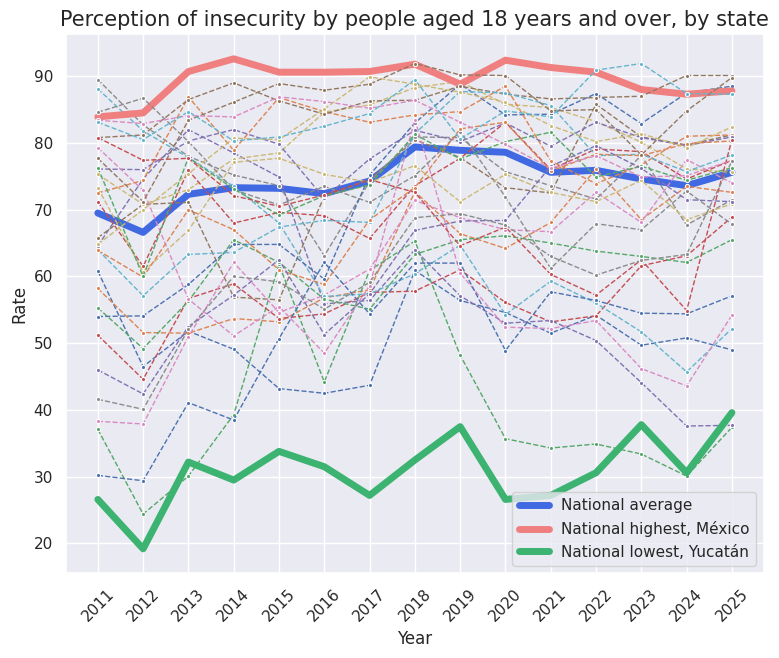

In [51]:
sns.set_theme(rc={'figure.figsize':(9,7)})
for state in new_security_by_state.columns:
    if state == 'Estados Unidos Mexicanos':
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linewidth = 5, label = 'National average', color = 'royalblue')
    elif state == 'Yucatán':
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linewidth = 5, label = 'National lowest, Yucatán', color = 'mediumseagreen')  
    elif state == 'México':
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linewidth = 5, label = 'National highest, México', color = 'lightcoral')        
    else:
        sns.lineplot(x = new_security_by_state.index, y = new_security_by_state[state], linestyle='dashed', linewidth = 1, marker = '.')

plt.xlabel('Year')
plt.ylabel('Rate')
plt.xticks(rotation=45)
plt.title('Perception of insecurity by people aged 18 years and over, by state', wrap = True, size = 15)

Given the amount of states (32), this plot looks quite confusing and it's hard to gather much information. However, what is is visible is that, based on the national average, the level of perceived insecurity in the country is quite high.

To get more insights on individual states, more statistical calculations are carried out: 

1) the states with the lowest and highest levels of insecurity (absolute and average) are found 
2) the change rate in perceived insecurity from 2011 to 2025 is calculated, to show if overall the perception of security has improved or worsened.

### 4.3 Rate of change in perceived insecurity

For every state, [Numpy Polyfit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html) is used to calculate the polynomial coefficients bewteen state and years (2011-2015). 
The polynomial coefficients consist of the slope (or steepness) of the line fitting the data, while the second represents the intercept (where the line meets the Y ax). 

Source: https://www.w3schools.com/datascience/ds_linear_slope.asp.  

Values in the dataframe are converted to percentages: 75638.192481 / 100 000 inhabitants -> 75,6%. Years are converted to numbers (integers).

In [30]:
# convert values to % and round. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.round.html
for col in new_security_by_state: 
    new_security_by_state[col] = round(new_security_by_state[col] * 100 / 100000, 1)

# convert years from strings to integers
years = new_security_by_state.index.astype(int)

new_security_by_state.head(5)

state,Estados Unidos Mexicanos,Aguascalientes,Baja California,Baja California Sur,Campeche,Coahuila de Zaragoza,Colima,Chiapas,Chihuahua,Ciudad de México,...,Quintana Roo,San Luis Potosí,Sinaloa,Sonora,Tabasco,Tamaulipas,Tlaxcala,Veracruz de Ignacio de la Llave,Yucatán,Zacatecas
2011,69.5,60.8,58.2,37.1,51.2,64.6,65.8,38.3,89.5,75.3,...,63.9,76.3,80.8,46.0,77.7,83.4,41.6,64.8,26.6,83.1
2012,66.6,46.5,51.6,24.4,44.6,74.6,70.8,37.9,82.7,70.8,...,59.9,60.0,77.4,42.4,71.2,82.9,40.1,70.0,19.2,80.5
2013,72.3,51.8,51.5,30.1,56.7,82.0,71.1,51.0,78.0,73.0,...,70.0,77.8,77.7,52.5,83.4,84.1,52.1,75.4,32.2,84.7
2014,73.3,49.1,53.7,39.3,58.9,78.5,56.9,62.1,75.2,77.6,...,67.0,73.1,72.1,57.2,86.1,83.9,60.0,80.7,29.5,80.3
2015,73.2,43.2,53.2,61.8,53.7,74.9,56.5,54.6,73.6,78.5,...,61.0,69.2,70.5,62.5,88.9,86.9,59.2,80.5,33.8,80.9


Numpy.polyfit is used to calculate the slope of the trend for each state. A new dataframe is created to store state name and slope value. 

In [31]:
# calculate slopes using numpy.polyfit: https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
# create empty dataframe with state and slope columns. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html
slopes = pd.DataFrame(data= {'state' : [], 'slope' : []})

for state in new_security_by_state:
    slope = np.polyfit(years, new_security_by_state[state], 1)[0]
    slope = np.round(slope, decimals = 1)
    # append row to df slopes. see: https://www.geeksforgeeks.org/pandas/how-to-add-one-row-in-an-existing-pandas-dataframe/
    slopes.loc[len(slopes)] = [state, slope]

# show dataframe
slopes.head()

,state,slope
0,Estados Unidos Mexicanos,0.5
1,Aguascalientes,0.1
2,Baja California,1.7
3,Baja California Sur,-0.3
4,Campeche,0.9


Based on the value of the slope, the state's perceived security is classified as: 

- **improving**: if the value of the slope is less then -0.1, it means that overall, between 2011 and 2025, the level of insecurity perceived by inhabitants has decreased;
- **stable**: if the value of the slope is between -0.1 and 0.1, it means that overall, between 2011 and 2025, the level of insecurity perceived by inhabitants has remained stable;
- **declining**: if the value of the slope is more then 0.1, it means that overall, between 2011 and 2025, the level of insecurity perceived by inhabitants has increased. 

In [32]:
# classify slope (perceived insecurity)
def classify_trend(row):
    if row['slope'] < -0.1:
        return 'improving'
    elif row['slope'] > 0.1:
        return 'worsening'
    else:
        return 'stable'

# add trends to dataframe. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
slopes['trend'] = slopes.apply(classify_trend, axis=1)

In [33]:
# show trends
slopes

,state,slope,trend
0,Estados Unidos Mexicanos,0.5,worsening
1,Aguascalientes,0.1,stable
2,Baja California,1.7,worsening
3,Baja California Sur,-0.3,improving
4,Campeche,0.9,worsening
5,Coahuila de Zaragoza,-2.8,improving
6,Colima,1.4,worsening
7,Chiapas,2.4,worsening
8,Chihuahua,-0.7,improving
9,Ciudad de México,0.4,worsening


#### Plot trends in preceived security (2011-2025)

Text(0.5, 1.0, 'Rate of change in perceived insecurity from 2011 to 2025')

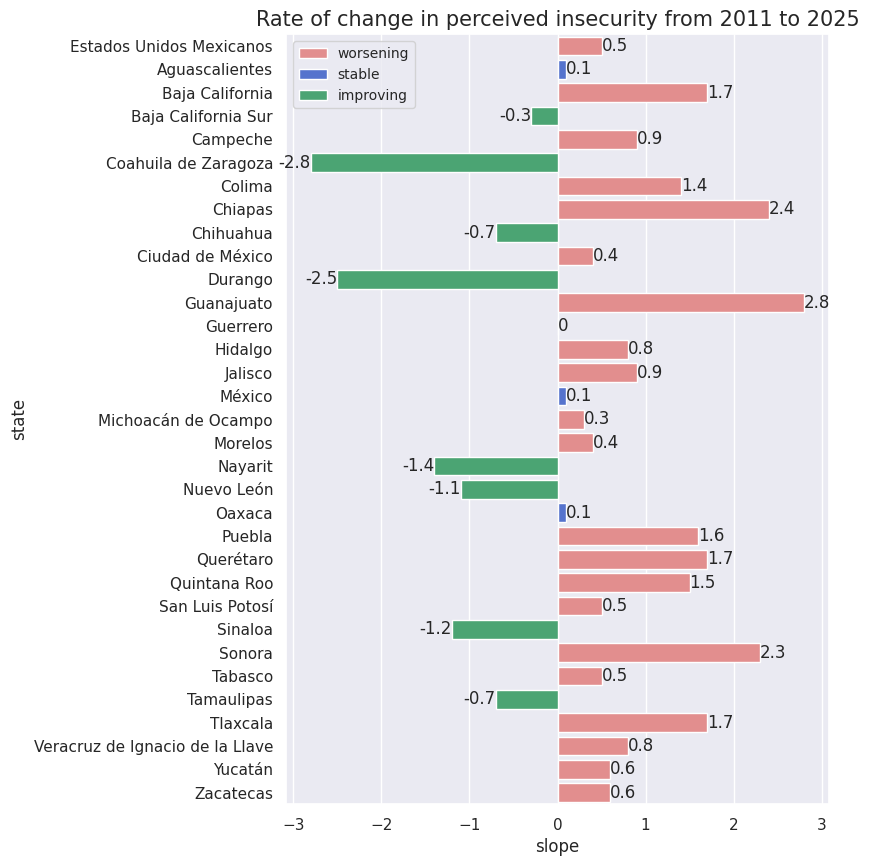

In [53]:
# https://seaborn.pydata.org/generated/seaborn.set_theme.html
# https://seaborn.pydata.org/generated/seaborn.color_palette.html
sns.set_theme(rc={'figure.figsize':(7,10)},color_codes=True, palette= ['lightcoral', 'royalblue', 'mediumseagreen'])
# https://seaborn.pydata.org/generated/seaborn.barplot.html
ax = sns.barplot(slopes, x = 'slope', y = 'state', hue = 'trend')


for container in ax.containers:
    ax.bar_label(container)

plt.legend(fontsize =  'small')
plt.title('Rate of change in perceived insecurity from 2011 to 2025', size = 15)

#### 4.4 Perception of insecurity in 2025, by state 

In [35]:
# Create map with .shp file 
map = gpd.read_file('./data/map/mex_admin1.shp')

# preview map table
map.head(5)

,adm1_name,adm1_name1,adm1_name2,adm1_name3,adm1_pcode,adm0_name,adm0_name1,adm0_name2,adm0_name3,adm0_pcode,...,area_sqkm,version,lang,lang1,lang2,lang3,adm1_ref_n,center_lat,center_lon,geometry
0,Aguascalientes,None,None,None,MX01,México,None,None,None,MX,...,5615.670486,v02,es,None,None,None,Aguascalientes,22.040951,-102.313154,"POLYGON ((-102.28787 22.41649, -102.28753 22.4..."
1,Baja California,None,None,None,MX02,México,None,None,None,MX,...,72853.585755,v02,es,None,None,None,Baja California,30.359352,-115.244131,"MULTIPOLYGON (((-114.79201 32.63022, -114.8019..."
2,Baja California Sur,None,None,None,MX03,México,None,None,None,MX,...,71966.826398,v02,es,None,None,None,Baja California Sur,25.435938,-111.543005,"MULTIPOLYGON (((-113.30833 28, -113.3 28, -113..."
3,Campeche,None,None,None,MX04,México,None,None,None,MX,...,55497.841605,v02,es,None,None,None,Campeche,19.330708,-89.943250,"MULTIPOLYGON (((-90.37936 20.84833, -90.38182 ..."
4,Chiapas,None,None,None,MX07,México,None,None,None,MX,...,72668.453027,v02,es,None,None,None,Chiapas,16.260164,-92.245241,"MULTIPOLYGON (((-93.27772 17.98235, -93.27738 ..."


In [36]:
# get 2025 data 
latest_insecurity_data = {}
for state in new_security_by_state.columns:
        if state != 'Estados Unidos Mexicanos':
            #latest_insecurity_data.update({state: new_security_by_state[state].iloc[-1]})
            latest_insecurity_data.update({state: round(new_security_by_state[state].iloc[-1]/1000,1)})

latest_insecurity_data

{'Aguascalientes': np.float64(0.0),
 'Baja California': np.float64(0.1),
 'Baja California Sur': np.float64(0.0),
 'Campeche': np.float64(0.1),
 'Coahuila de Zaragoza': np.float64(0.0),
 'Colima': np.float64(0.1),
 'Chiapas': np.float64(0.1),
 'Chihuahua': np.float64(0.1),
 'Ciudad de México': np.float64(0.1),
 'Durango': np.float64(0.1),
 'Guanajuato': np.float64(0.1),
 'Guerrero': np.float64(0.1),
 'Hidalgo': np.float64(0.1),
 'Jalisco': np.float64(0.1),
 'México': np.float64(0.1),
 'Michoacán de Ocampo': np.float64(0.1),
 'Morelos': np.float64(0.1),
 'Nayarit': np.float64(0.1),
 'Nuevo León': np.float64(0.1),
 'Oaxaca': np.float64(0.1),
 'Puebla': np.float64(0.1),
 'Querétaro': np.float64(0.1),
 'Quintana Roo': np.float64(0.1),
 'San Luis Potosí': np.float64(0.1),
 'Sinaloa': np.float64(0.1),
 'Sonora': np.float64(0.1),
 'Tabasco': np.float64(0.1),
 'Tamaulipas': np.float64(0.1),
 'Tlaxcala': np.float64(0.1),
 'Veracruz de Ignacio de la Llave': np.float64(0.1),
 'Yucatán': np.float6

In [37]:
# adapted from chatGPT: https://chatgpt.com/s/t_6958d857aa10819183507d0af0bbaa53
# map to existing file 
map["2025_insecurity_state"] = map["adm1_name"].map(latest_insecurity_data)

# preview state and insecurity value
map[["adm1_name", "2025_insecurity_state"]].head()

,adm1_name,2025_insecurity_state
0,Aguascalientes,0.0
1,Baja California,0.1
2,Baja California Sur,0.0
3,Campeche,0.1
4,Chiapas,0.1


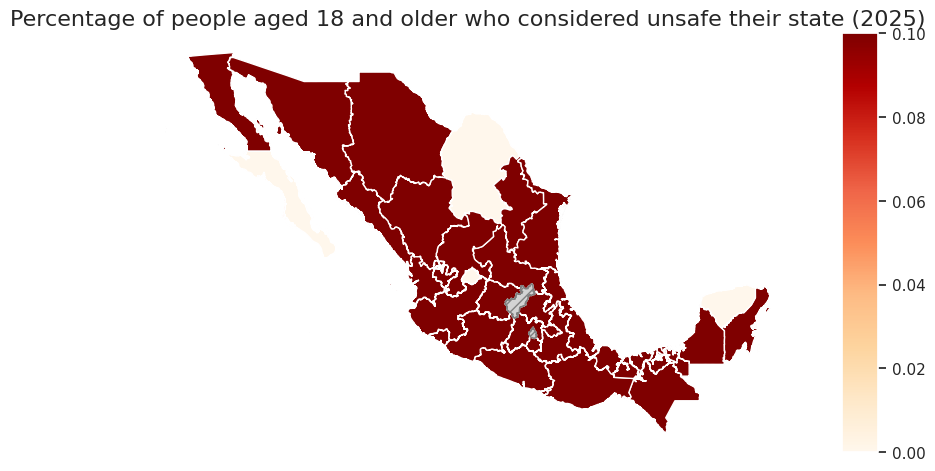

In [38]:
# https://nbviewer.org/github/pysal/inequality/blob/main/docs/user-guide/measure/theil.ipynb
# https://www.youtube.com/watch?v=aGPQXD-rLgw
# legend: https://geopandas.org/en/stable/docs/user_guide/mapping.html#creating-a-legend
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_axis_off.html


fig, ax = plt.subplots(1, 1, figsize=(10, 10)) 
divider = make_axes_locatable(ax) 

cax = divider.append_axes("right", size="5%", pad=0.1) 
map.plot(
    column='2025_insecurity_state',
    ax=ax,
    cax=cax,
    legend=True,
    #legend_kwds={"label": "Rate every 100,000 inhabitants", "orientation": "vertical"},
    cmap='OrRd', 
    missing_kwds={"color": "lightgrey", "edgecolor": "Grey", "hatch": "///"}
);
ax.set_axis_off()
ax.set_title('Percentage of people aged 18 and older who considered unsafe their state (2025)', size = 16)
plt.show()

#plt.legend()
# https://share.google/aimode/U1k86IMoMlSjQWVUh


## 5. Analysis: Crime rates based on depositions (2025)

#### Data preparation 

In [39]:
# select subset for depositions 
depositions = data[(data['indicator'].str.contains('depositions of') |data['indicator'].str.contains('witnessed') ) & (data['state ID'] == 0)]

# select only 2 columns: indicator, 2025
depositions = depositions.loc[:,['state','indicator ID','indicator','2025']]

# set indicator as index
depositions.set_index('indicator ID', inplace = True)

# preview 
depositions.head()

,state,indicator,2025
indicator ID,,,
6200028417,Estados Unidos Mexicanos,Percentage of depositions of frequent shots,34.357405
6200028418,Estados Unidos Mexicanos,Percentage of depositions of venues invasion,18.447114
6200028419,Estados Unidos Mexicanos,Percentage of depositions of alcohol consumpti...,63.801925
6200028420,Estados Unidos Mexicanos,Percentage of depositions of homicide,23.728847
6200028421,Estados Unidos Mexicanos,Percentage of depositions of unspecified,0.274053


In [40]:
# make indicators shorter and set as titles 
# see: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.replace.html 
# see: https://pandas.pydata.org/docs/reference/api/pandas.Series.str.title.html#pandas.Series.str.title
depositions['Offense'] = depositions['indicator'].str.replace('Percentage of', '', regex = False)
depositions['Offense'] = depositions['Offense'].str.replace('depositions of', '', regex = False).str.title()

In [41]:
depositions['Rate'] = depositions['2025'].round(decimals=1)

In [42]:
# sort values. see: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
depositions.sort_values(by=['2025'], ascending=False, inplace = True)

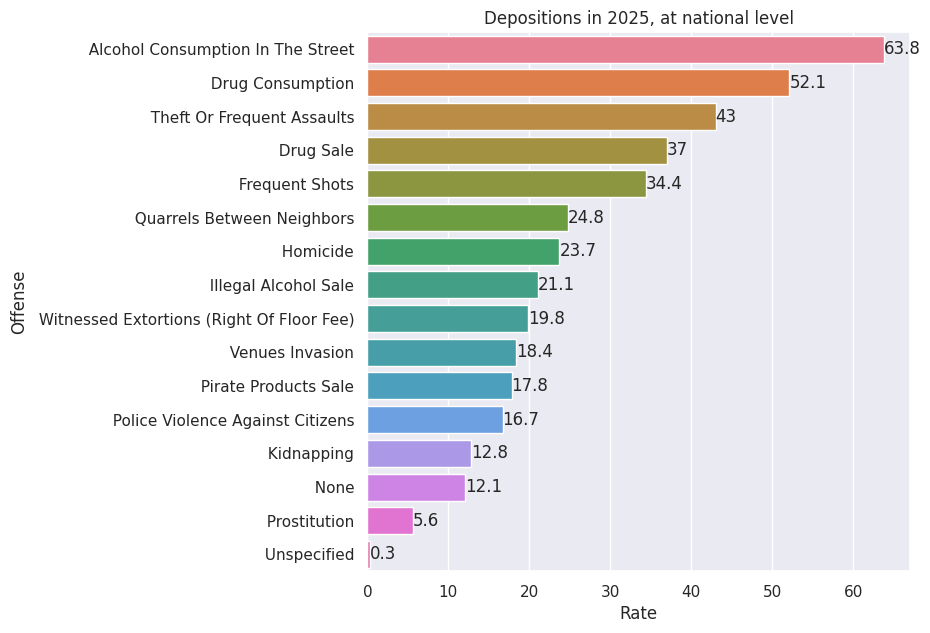

In [43]:
# https://seaborn.pydata.org/generated/seaborn.barplot.html
sns.set_theme(rc={'figure.figsize':(7,7)}, palette='pastel')
ax = sns.barplot(depositions, x = 'Rate' , y = 'Offense', hue = 'Offense')

for container in ax.containers:
    ax.bar_label(container)

plt.title('Depositions in 2025, at national level')
plt.show()

## 5. Conclusion

## End

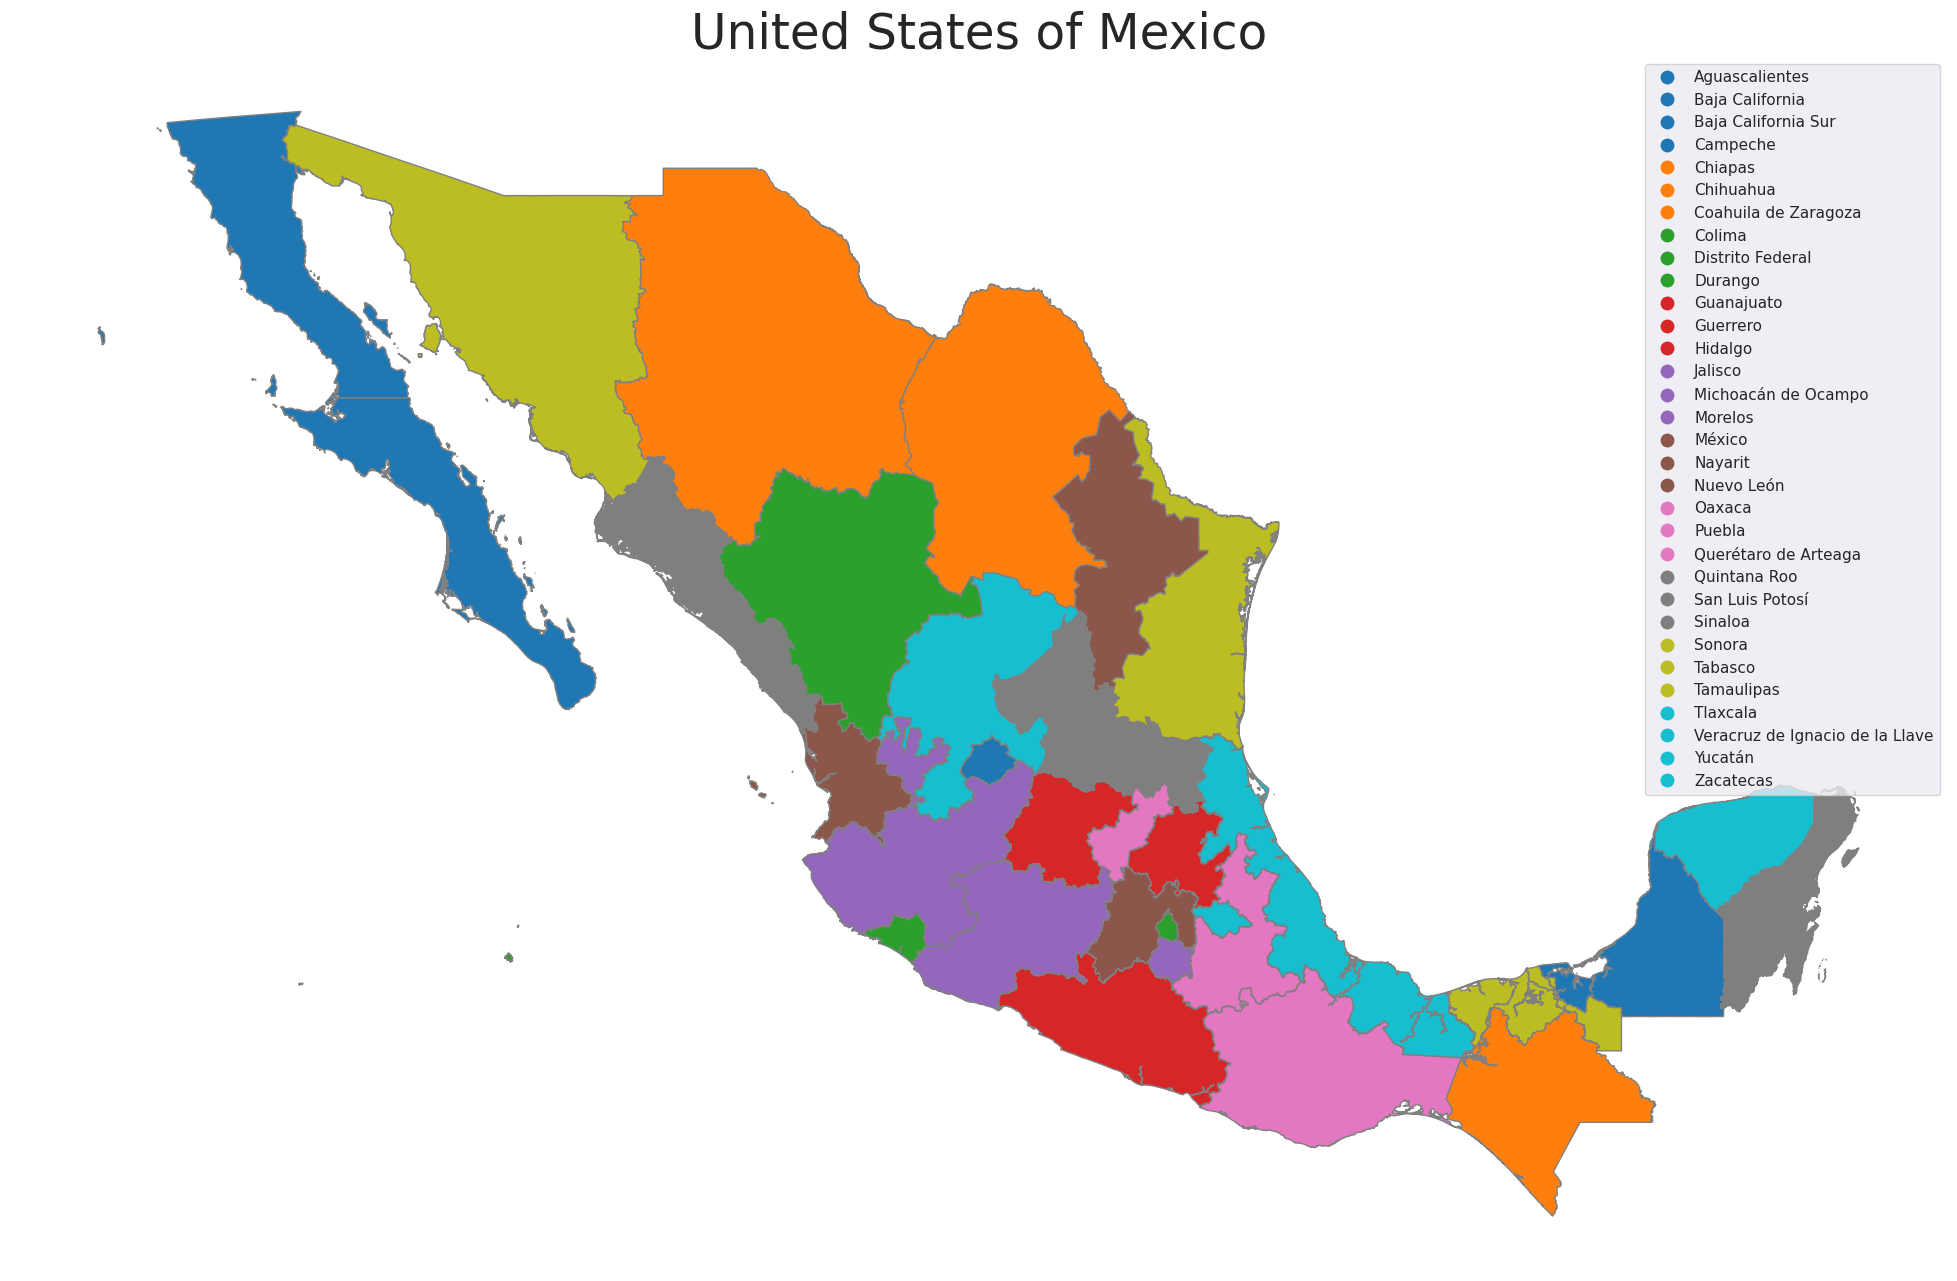

In [44]:
plt.rcParams['figure.figsize'] = [25, 25]
map.plot(column='adm1_name', legend=True, edgecolor="grey")
plt.title('United States of Mexico', size = 35)
plt.axis('off')

plt.show()